<h2 align=center> Facial Expression Recognition with Keras</h2>

### Task 1: Import Libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.2.0


### Task 2: Plot Sample Image

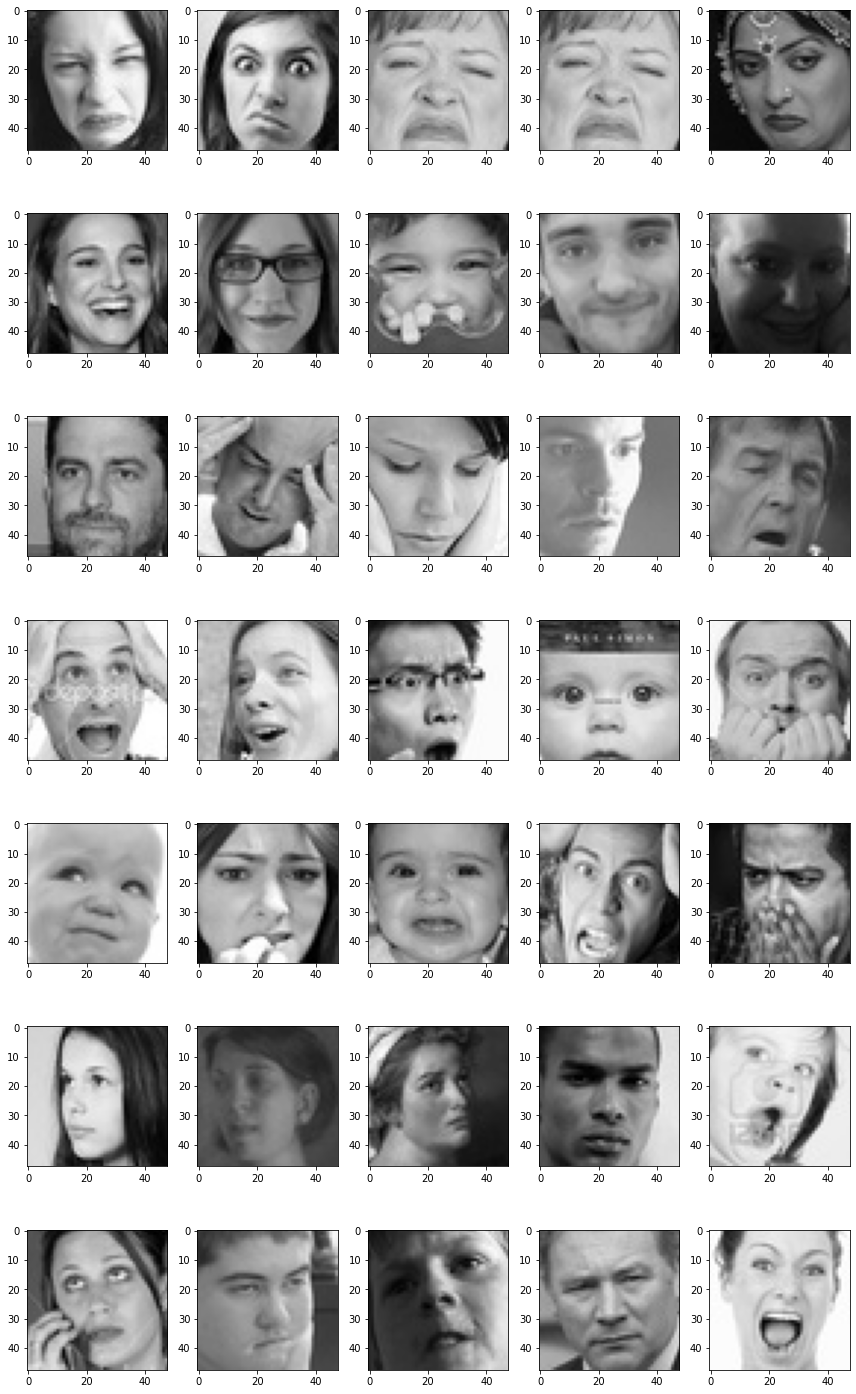

In [2]:
utils.datasets.fer.plot_example_images(plt).show()

In [3]:
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/" + expression))) + " " + expression + " images")

436 disgust images
7215 happy images
4830 sad images
3171 surprise images
4097 fear images
4965 neutral images
3995 angry images


### Task 3: Generate Training and Validation Batches

In [4]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory("train/", target_size=(img_size, img_size), 
                                                    color_mode='grayscale', 
                                                    batch_size=batch_size, 
                                                    class_mode='categorical', 
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_train.flow_from_directory("test/", target_size=(img_size, img_size), 
                                                    color_mode='grayscale', 
                                                    batch_size=batch_size, 
                                                    class_mode='categorical', 
                                                    shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Task 4: Create CNN Model

![](model.png)
Inspired by Goodfellow, I.J., et.al. (2013). Challenged in representation learning: A report of three machine learning contests. *Neural Networks*, 64, 59-63. [doi:10.1016/j.neunet.2014.09.005](https://arxiv.org/pdf/1307.0414.pdf)

In [18]:
model = Sequential()

# 1 - conv block
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2 - conv block
model.add(Conv2D(128, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3 - conv block
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 4 - conv block
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# flattening model
model.add(Flatten())

# 1st - fully connected layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# 2nd - fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# activating softmax
model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_12 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_12 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_13 (Batc (None, 24, 24, 128)      

### Task 6: Train and Evaluate Model

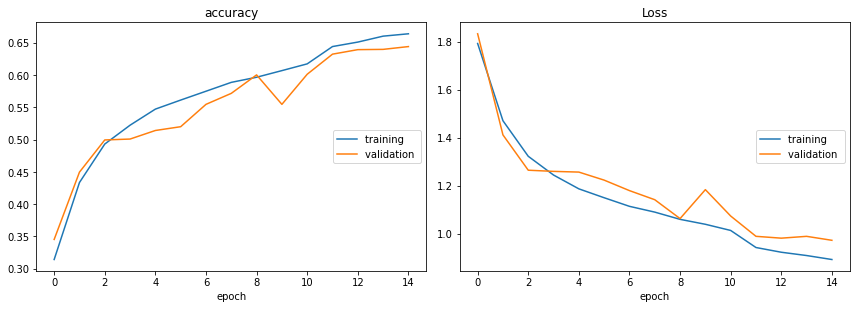

accuracy
	training         	 (min:    0.309, max:    0.775, cur:    0.664)
	validation       	 (min:    0.335, max:    0.675, cur:    0.644)
Loss
	training         	 (min:    0.612, max:    1.805, cur:    0.893)
	validation       	 (min:    0.946, max:    1.960, cur:    0.973)

Epoch 00015: saving model to model_weights.h5
448/448 [==============================] - 68s 151ms/step - loss: 0.8927 - accuracy: 0.6636 - val_loss: 0.9727 - val_accuracy: 0.6438 - lr: 5.0000e-05


In [19]:
epochs = 15

steps_per_epoch = train_generator.n//train_generator.batch_size

validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                            save_weights_only=True, mode='max', verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, 
                              min_lr=0.00001, model='auto')

callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks
)

### Task 7: Represent Model as JSON String

In [20]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)